# Read in the preprocessed data and calculate some statistics

In [1]:
import pickle

paper_preproc = pickle.load(open("../example_data/pre_CTRL_2012_2013.pkl", 'rb'))

paper_preproc = paper_preproc[(paper_preproc['long_duration'] >= 24) & (paper_preproc['100k_between']==True)].copy()

How many storms in 2012-2013 season?

In [2]:
paper_preproc.storm_num.nunique()

113

How many for each month?

In [3]:
first = paper_preproc.groupby('storm_num').first()

for m in [10, 11, 12, 1, 2, 3, 4]:
    
    month = first[first.start_time.dt.month==m]
    
    print("Month {} count: {}".format(m, len(month)))

Month 10 count: 10
Month 11 count: 18
Month 12 count: 22
Month 1 count: 21
Month 2 count: 16
Month 3 count: 15
Month 4 count: 11


Cumulative counts updated daily

C:\Users\ahaberlie1\AppData\Local\Continuum\anaconda3\envs\p37\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(0, 120)

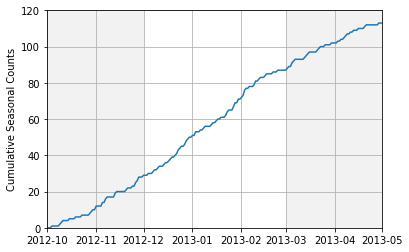

In [4]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

ax = plt.subplot(1,1,1)

#Get first timestep from storm
year_storm = paper_preproc.groupby('storm_num').first()

#set the storm index to the valid start time of the swath
year_storm = year_storm.set_index('start_time', drop=False)

#resample the first instances by day
counts = year_storm.resample('D').count()

#Set up the days between the start and end of the season
rng = pd.date_range(start='2012-10-01', end='2013-05-01', freq='1D')

#create empty DataFrame with all of the dates
df_day = pd.DataFrame(columns=['date'], data=rng)
df_day = df_day.set_index('date')

#join the counts to the empty dataset and put zeros 
#where there aren't any storms
df_counts = df_day.join(counts).fillna(0)

#set a new column 'dsum' to the counts
df_counts['dsum'] = df_counts['start_time'].values

#calculate the cumulative sum over each day
csum = df_counts[['dsum']].cumsum()

#plot the cumulative sums
ax.plot(csum.index, csum.dsum)

ax.axvspan(datetime.datetime(2012, 10, 1), datetime.datetime(2012, 12, 1), facecolor='0.5', alpha=0.1)
ax.axvspan(datetime.datetime(2013, 3, 1), datetime.datetime(2013, 5, 1), facecolor='0.5', alpha=0.1)
ax.grid()
ax.set_ylabel("Cumulative Seasonal Counts")
ax.set_xlim([datetime.date(2012, 10, 1), datetime.date(2013, 5, 1)])
ax.set_ylim(0, 120)

What is the cumulative duration for 2012-2013?

In [5]:
import numpy as np

np.sum(first.long_duration)

6771.0

What is the cumulative SWE (in cubic km) for 2012-2013?

In [6]:
np.sum(paper_preproc[paper_preproc.start_time.dt.month.isin([10,11,12,1,2,3,4])].total_SWE_km3)

1093.2779023889059

What is the monthly SWE (in cubic km) for 2012-2013

In [7]:
for m in [10, 11, 12, 1, 2, 3, 4]:
    
    month = paper_preproc[paper_preproc.start_time.dt.month==m]
    
    print("Month {} count: {}".format(m, np.sum(month.total_SWE_km3)))

Month 10 count: 55.421314774431835
Month 11 count: 106.74364582330776
Month 12 count: 248.91107285960436
Month 1 count: 154.58581605279528
Month 2 count: 185.18036672749457
Month 3 count: 170.84145455669113
Month 4 count: 171.594231594581


Cumulative SWE updated daily

(0, 1200)

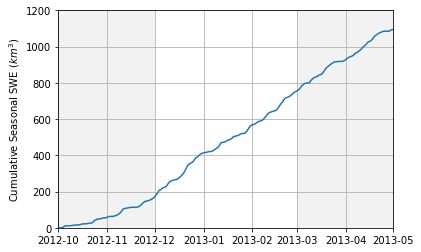

In [8]:
import datetime

ax = plt.subplot(1,1,1)

#resample the first instances by day
counts = paper_preproc.resample('D').sum()

#Set up the days between the start and end of the season
rng = pd.date_range(start='2012-10-01', end='2013-05-01', freq='1D')

#create empty DataFrame with all of the dates
df_day = pd.DataFrame(columns=['date'], data=rng)
df_day = df_day.set_index('date')

#join the counts to the empty dataset and put zeros 
#where there aren't any storms
df_counts = df_day.join(counts).fillna(0)

#set a new column 'dsum' to the counts
df_counts['dsum'] = df_counts['total_SWE_km3'].values

#calculate the cumulative sum over each day
csum = df_counts[['dsum']].cumsum()

#plot the cumulative sums
ax.plot(csum.index, csum.dsum)

ax.axvspan(datetime.datetime(2012, 10, 1), datetime.datetime(2012, 12, 1), facecolor='0.5', alpha=0.1)
ax.axvspan(datetime.datetime(2013, 3, 1), datetime.datetime(2013, 5, 1), facecolor='0.5', alpha=0.1)
ax.grid()
ax.set_ylabel("Cumulative Seasonal SWE $(km^3)$")
ax.set_xlim('2012-10-01', '2013-05-01')
ax.set_ylim(0, 1200)

What is the cumulative swath area for 2012-2013?

First, calculate maximum extent for each swath.

Swath extent for CTRL_2012_2013_22164 is:  2809184.0


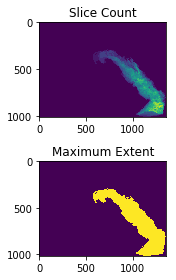

In [9]:
example = paper_preproc[paper_preproc.storm_num=='CTRL_2012_2013_22164']

result_slice = np.zeros(shape=(1015, 1359))
result_extent = np.zeros(shape=(1015, 1359))

for group in example.coords.values:
    
    y, x = group[:, 0], group[:, 1]
    result_slice[y, x] += 1
    result_extent[y, x] = 1
   
ax = plt.subplot(2,1,1)
ax.imshow(result_slice)
ax.set_title("Slice Count")

ax = plt.subplot(2,1,2)
ax.imshow(result_extent)
ax.set_title("Maximum Extent")

plt.tight_layout()

print("Swath extent for CTRL_2012_2013_22164 is: ", 16*np.sum(result_extent))

Do this for multiple swaths

In [10]:
import numpy as np
import pandas as pd

ctrl_res = {'storm_num':[], 'season':[], 'start_date':[], "end_date":[],
           'duration':[], 'swe':[], 'swath_area':[], 'swath_area_50p':[], 'swath_area_90p':[]}

for sid, storm in paper_preproc.groupby('storm_num'):
    
    a = np.zeros(shape=(1015, 1359))
    a50 = np.zeros(shape=(1015, 1359))
    a90 = np.zeros(shape=(1015, 1359))
    
    ctrl_res['storm_num'].append(sid)
    ctrl_res['start_date'].append(np.min(pd.to_datetime(storm.index)))
    ctrl_res['end_date'].append(np.max(pd.to_datetime(storm.index)))
    ctrl_res['duration'].append(storm['long_duration'].values[0])
    ctrl_res['season'].append(storm.season.values[0])
    ctrl_res['swe'].append(np.sum(storm['total_SWE_km3'].values))
    
    for group in storm.coords.values:
        
        y, x = group[:, 0], group[:, 1]
        a[y, x] = 1
        
    for group in storm.coords_50p.values:

        if len(group) > 0:
            y, x = group[:, 0], group[:, 1]
            a50[y, x] = 1

    for group in storm.coords_90p.values:

        if len(group) > 0:
            y, x = group[:, 0], group[:, 1]
            a90[y, x] = 1

    ctrl_res['swath_area'].append(np.sum(a) * 16)
    ctrl_res['swath_area_50p'].append(np.sum(a50) * 16)
    ctrl_res['swath_area_90p'].append(np.sum(a90) * 16)

ctrl_res = pd.DataFrame.from_dict(ctrl_res)

Cumulative area, 50th percentile area, and 90th percentile area for 2012-2013

In [11]:
print("Area {}\n50th Area {}\n90th Area {}".format(ctrl_res['swath_area'].sum(),
                                                   ctrl_res['swath_area_50p'].sum(),
                                                   ctrl_res['swath_area_90p'].sum()))

Area 214452848.0
50th Area 159574944.0
90th Area 60417744.0
